<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data-Filtering" data-toc-modified-id="Data-Filtering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Filtering</a></span></li></ul></div>

# Background

In the study by Cutter et al. [Disaster Resilience Indicators for Benchmarking Baseline Conditions](Cutter_jhsem.2010.7.1.1732.pdf), the investigators provided a case study to _"illustrate the scalability of the resilence metric and to articulate the significance of a component-based approach for objective measurement"_.

In this notebook, we attempt to recreate their case study to exercise:

1. our understanding of their methodology using our datasets
1. scientific reproducibility

Cutter et al. selected 13 counties from 3 metropolitan statistical areas because they were _"highly diverse in terms of population, income, racial and ethnic identity, and age"_. In particular, they chose these 3 metropolitan areas _"since they are primary test beds of the Community and Regional Resilience Institute (CARRI)"_:

1. Gulfport-Biloxi, Mississippi
1. Charleston-North Charleston, South Carolina
1. Memphis, Tennessee

Below we display Table 3 from the Cutter et al. study which shows the 13 counties included in the case study, their composite scores for each of the disaster resilience components (social, economic, institutional, infrastructure, community capital), the aggregate resilience scores (sum of components scores), and the average resilience score for each metropolitan area (mean of the aggregate resilience score for each county in each metropolitan area):

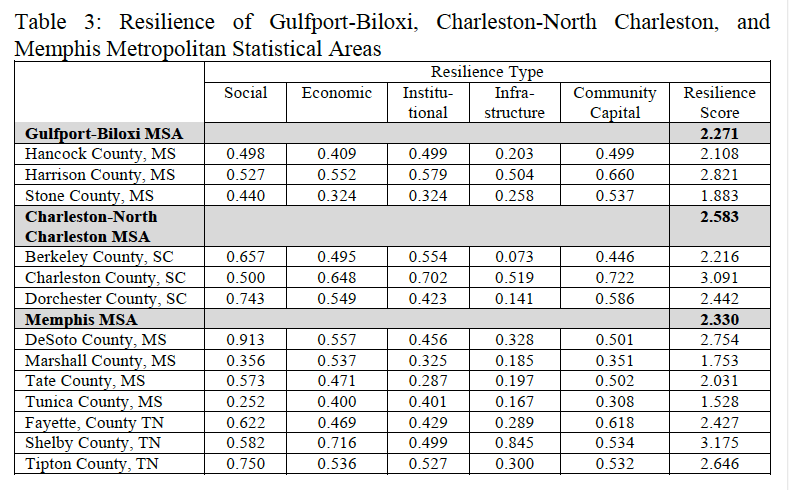

Below we display Figure 4 from the study to show the spatial distribution of the 13 counties in the 3 metropolitan areas:

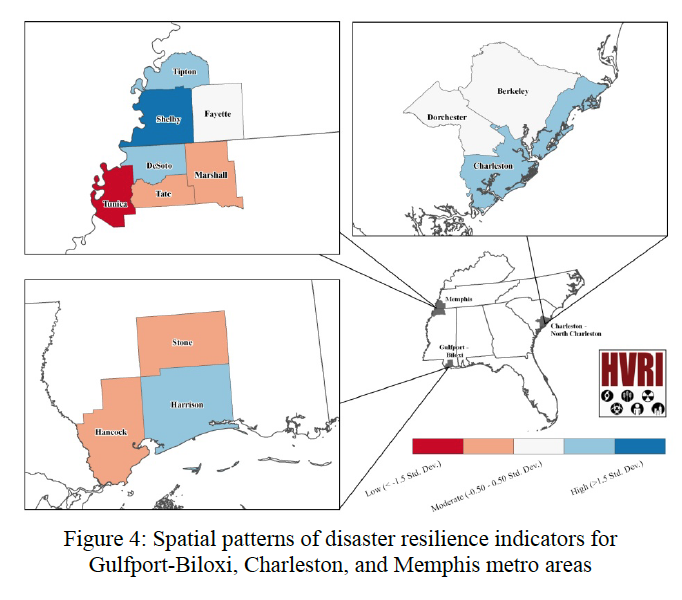

# Data Filtering

To recreate the above analysis, we must first filter down to the 13 counties used. The study did not give the FIPS codes for each county so we must perform a manual exercise of extracting those FIPS codes. Let's try to do that using code.

First let's setup our environment:

In [1]:
import os, sys, re, json, time
import matplotlib
from copy import deepcopy
from subprocess import check_output
import netCDF4 as NC
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoJSON, Choropleth
from ipywidgets import Layout, link, FloatSlider, Label, VBox
from astropy.time import Time
from IPython.display import display, HTML, Markdown
from branca.colormap import linear, LinearColormap
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, mapping
import geojson
import seaborn as sns

sns.set_style('white')

%matplotlib inline

and read in the US county shapefile:

In [2]:
def get_us_multipolygon():
    """Return multipolygon of US counties."""
    
    counties_shp = os.path.join("geo_data", "counties", "cb_2017_us_county_500k.shp")
    us = gpd.read_file(counties_shp)
    us = us.to_crs(epsg=4326) # reproject to -180, 180
    return us
    
# get geopandas data frame of US county polygons
us_polys = get_us_multipolygon()

Let's remind ourselves of how this dataset looks like:

In [3]:
display(us_polys.head())

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425..."
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37..."
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.76244200000001, -87.86..."


We note that the `NAME` field contains the name of the county. Perhaps we can filter down to the 13 counties by matching on this field. Let's first create a list of the 13 county names by eyeballing them from table 3 above:

In [4]:
county_names = [
    'Hancock',
    'Harrison',
    'Stone',
    'Berkeley',
    'Charleston',
    'Dorchester',
    'DeSoto',
    'Marshall',
    'Tate',
    'Tunica',
    'Fayette',
    'Shelby',
    'Tipton'
]

Because we cannot assume county name uniqeness, let's see how many matches we get for each county name:

In [5]:
for cn in county_names:
    # match county name verbatim
    matches = us_polys[us_polys['NAME'] == cn]
    print("County {} has {} matches.".format(cn, len(matches)))

County Hancock has 10 matches.
County Harrison has 8 matches.
County Stone has 3 matches.
County Berkeley has 2 matches.
County Charleston has 1 matches.
County Dorchester has 2 matches.
County DeSoto has 2 matches.
County Marshall has 12 matches.
County Tate has 1 matches.
County Tunica has 1 matches.
County Fayette has 11 matches.
County Shelby has 9 matches.
County Tipton has 2 matches.


All county names have more than one match except for Charleston, Tate, and Tunica. To make sure we filter down to the correct ones used in the study, we should filter additionally by state. Note that we also cannot assume, though highly unlikely, that each state has counties with unique county names.

We know from table 3 above that each county has an associated state denoted by the state abbreviation. Let's update our `county_names` data structure from a list of counties to a list of `(county name, state)`:

In [6]:
county_names = [
    [ 'Hancock',    'MS' ],
    [ 'Harrison',   'MS' ],
    [ 'Stone',      'MS' ],
    [ 'Berkeley',   'SC' ],
    [ 'Charleston', 'SC' ],
    [ 'Dorchester', 'SC' ],
    [ 'DeSoto',     'MS' ],
    [ 'Marshall',   'MS' ],
    [ 'Tate',       'MS' ],
    [ 'Tunica',     'MS' ],
    [ 'Fayette',    'TN' ],
    [ 'Shelby',     'TN' ],
    [ 'Tipton',     'TN' ],
]

Let's take a look at the `us_polys` data again:

In [7]:
display(us_polys.head())

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425..."
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37..."
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.76244200000001, -87.86..."


Note the field `STATEFP`. This field contains a 2-digit code that corresponds to the state FIPS code. A quick google will give us a [table of state abbreviations to FIPS code](https://www.mcc.co.mercer.pa.us/dps/state_fips_code_listing.htm).

Since there are only 3 state abbreviations we need to worry about, MS, SC and TN, let's create a dict that maps from state abbreviation to FIPS code:

In [8]:
state2fips = {
    'MS': '28',
    'SC': '45',
    'TN': '47',
}

And see how many matches we get for each county/state:

In [9]:
for cn, sa in county_names:
    # match by county name and state fips code
    matches = us_polys[(us_polys['NAME'] == cn) & (us_polys['STATEFP'] == state2fips[sa])]
    print("County {} has {} matches.".format(cn, len(matches)))

County Hancock has 1 matches.
County Harrison has 1 matches.
County Stone has 1 matches.
County Berkeley has 1 matches.
County Charleston has 1 matches.
County Dorchester has 1 matches.
County DeSoto has 1 matches.
County Marshall has 1 matches.
County Tate has 1 matches.
County Tunica has 1 matches.
County Fayette has 1 matches.
County Shelby has 1 matches.
County Tipton has 1 matches.


Bingo! Let's filter down on these:

In [10]:
def filter_county_state(x):
    """Filter by county name and state."""
    
    for cn, sa in county_names:
        if x['NAME'] == cn and x['STATEFP'] == state2fips[sa]:
            return True
    return False

# subset to the 13 counties
case_study_polys = us_polys[us_polys.apply(filter_county_state, axis=1)]

# rename GEOID to fips and set fips as the index
case_study_fips = case_study_polys.rename(index=str, columns={"GEOID": "fips"}).set_index('fips')

# display all 13
display(case_study_fips)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry
fips,,,,,,,,,
28033,28,033,00695741,0500000US28033,DeSoto,06,1233556699,53624068,"POLYGON ((-90.31000499999999 34.875097, -90.30..."
45035,45,035,01247998,0500000US45035,Dorchester,06,1484540310,6724254,"POLYGON ((-80.789924 33.179426, -80.790296 33...."
47157,47,157,01639790,0500000US47157,Shelby,06,1977720315,55485268,"POLYGON ((-90.31029799999999 35.004295, -90.30..."
47167,47,167,01639795,0500000US47167,Tipton,06,1187267191,38609225,"(POLYGON ((-90.046598 35.412966, -90.045306 35..."
28137,28,137,00695789,0500000US28137,Tate,06,1048332509,16090912,"POLYGON ((-90.24392399999999 34.60215, -90.241..."
45015,45,015,01247985,0500000US45015,Berkeley,06,2845745102,338007534,"POLYGON ((-80.361301 33.263077, -80.3591 33.27..."
28047,28,047,00695747,0500000US28047,Harrison,06,1486713863,1063618187,"(POLYGON ((-88.871763 30.385659, -88.865652 30..."
28045,28,045,00711756,0500000US28045,Hancock,06,1227560683,204096133,"POLYGON ((-89.68415700000001 30.459152, -89.67..."
47047,47,047,01639742,0500000US47047,Fayette,06,1825375565,3774866,"POLYGON ((-89.643916 35.006373, -89.643772 35...."


Let's visualize them to see if they match the spatial coverage of figure 4 from the study. Let's generate the map first:

In [11]:
# zoom in on the southeastern US
m = Map(center=[31, -85], zoom=6, layout=Layout(height='600px', align_self='stretch'))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Then let's plot the 13 counties:

In [12]:
l = GeoJSON(data=case_study_fips.__geo_interface__,
            hover_style={'fillColor': 'red'})
m.add_layer(l)

Comparing it to figure 4 from the study, it looks like we have the correct counties used in the case study.